# Seminario de Deep Learning sobre redes convolucionales
## Dataset de pokemones y huevos pokémon del juego Pokémon Reloaded

Equipo 
- Antonio Elias Sánchez Soto
- Daniela Mayté Vento Fernández
- Dayron Nuñez Chil 
- Yonathan Villavicencio Castillo

Los viejos encargados de la guardería pokémon necesitan ayuda. Desean actualizar su maquinaria para facilitar el trabajo. Se debe incorporar a sus nuevos robots ayudantes un modelo que distinga entre huevos de pokémon y pokemones. Para esto el doctor Oak como buen samaritano nos ha aportado una base de datos con las imágenes de todos los pokemones y huevos asociados.
El conjunto de entrenamiento cuenta con 452 imágenes de huevos y 1244 de pokemones. La validación cuenta con 131 huevos y 270 pokemones. 

## Carga del dataset

In [1]:
import os #trabajo con sistema, poder cargar imagenes
import tensorflow as tf #construccion de los modelos
import matplotlib.pyplot as plt #visualizaciones
import numpy as np #trabajo con arreglos
from tensorflow.keras.callbacks import TensorBoard #metricas
from tensorflow.keras.preprocessing.image import ImageDataGenerator #transformacion de imagenes para analisis adecuado por el modelo
from PIL import Image #lectura de imagenes

Es necesario declarar la ubicación de las imágenes para la conformación del modelo. Desde un principio se debe contar con las divisiones de aquellas aplicadas al entrenamiento y aquellas aplicadas para la validación.

In [2]:
#ubicaciones del dataset
entrenamiento = "Dataset/Entrenamiento"
validacion = "Dataset/Validacion"

# Verificar que las carpetas existan
if not os.path.exists(entrenamiento):
    raise Exception(f"La carpeta de entrenamiento no existe: {entrenamiento}")
if not os.path.exists(validacion):
    raise Exception(f"La carpeta de validación no existe: {validacion}")

#guardar lista de elemento en las carpetas (imagenes por clasificacion)
listaTrain = os.listdir(entrenamiento)
listaTest = os.listdir(validacion)

## Extracción de imágenes

Se debe organizar y transformar las imágenes divididas para que puedan ser entradas para el modelo. Redimensionar todas las imágenes a un tamaño uniforme ayudará a que cuando se lleve a escala de grises y luego a arreglo de NumPy el trabajo sea más adecuado para el modelo. 

In [3]:
#parametros
ancho, alto = 200, 200 #las imagenes son mas pequeñas, pero un tamaño mayor de parametro permite mejor análisis al transformarse

#asociados al entrenamiento
etiquetas = [] # Lista para almacenar etiquetas (clases: huevo o pokémon)
fotos = [] # Lista para almacenar las imágenes originales procesadas
datos_train = [] # Lista para almacenar las imágenes redimensionadas y preparadas
con = 0 # Contador para asignar etiquetas a las clases


#asociados a la validación
etiquetas2 = []
fotos2 = []
datos_vali = []
con2 = 0

# Extraccion de imagenes de entrenamiento
for nameDir in listaTrain:
    nombre = os.path.join(entrenamiento, nameDir) #huevo o pokémon
    
    for fileName in os.listdir(nombre):
        ruta_completa = os.path.join(nombre, fileName) #ruta del elemento
        try:
            # Usar PIL para leer la imagen
            img = Image.open(ruta_completa).convert('L')  # Convertir a escala de grises
            img = img.resize((ancho, alto), Image.Resampling.LANCZOS) #redimensionar todas a un mismo tamaño 200x200
            img = np.array(img) #convertir la imágen a arreglo NumPy
            
            etiquetas.append(con)  # Asignar etiqueta según la clase actual
            img = img.reshape(ancho, alto, 1)  # Agregar dimensión extra (canal único para escala de grises)
            datos_train.append(img)  # Agregar imagen preprocesada al conjunto de entrenamiento
            fotos.append(img)       # Agregar imagen original procesada a la lista general
        except Exception as e:
            print(f"Error procesando {ruta_completa}: {str(e)}")
            continue
    
    con += 1

# Extraccion de imagenes de validacion
for nameDir2 in listaTest:
    nombre2 = os.path.join(validacion, nameDir2)
    
    for fileName2 in os.listdir(nombre2):
        ruta_completa = os.path.join(nombre2, fileName2)
        try:
            # Usar PIL para leer la imagen
            img2 = Image.open(ruta_completa).convert('L')  # Convertir a escala de grises
            img2 = img2.resize((ancho, alto), Image.Resampling.LANCZOS)
            img2 = np.array(img2)
            
            etiquetas2.append(con2)
            img2 = img2.reshape(ancho, alto, 1)
            datos_vali.append(img2)
            fotos2.append(img2)
        except Exception as e:
            print(f"Error procesando {ruta_completa}: {str(e)}")
            continue
    
    con2 += 1

## Preprocesamiento

Es necesario asegurarnos de que las listas de fotos no estén vacías, sin información no se puede trabajar. El trabajo con arreglos de NumPy para tratar las fotos hace que sea posible el uso de bibliotecas como TensorFlow para el desarrollo del modelo. 

Las imágenes en escala de grises tienen píxeles entre 0 o 255, por lo que para normalizar se divide entre 255. La normalizació acelera el entrenamiento y mejora la estabilidad numérica. Las etiquetas también deben convertirse a datos numéricos para tener mayor precisión en las métricas.


In [4]:
# Verificar que tengamos datos para procesar
if not fotos:
    raise Exception("No se encontraron imágenes válidas en la carpeta de entrenamiento")
if not fotos2:
    raise Exception("No se encontraron imágenes válidas en la carpeta de validación")

# normalizacion de imagenes
fotos = np.array(fotos).astype('float32') / 255
print(fotos.shape)
fotos2 = np.array(fotos2).astype('float32') / 255
print(fotos2.shape)

etiquetas = np.array(etiquetas)
etiquetas2 = np.array(etiquetas2)

(1696, 200, 200, 1)
(401, 200, 200, 1)


El generador de aumento de datos es una técnica para generar nuevas imágenes a partir de las existentes mediante transformaciones aleatorias. Esto ayuda a que el modelo generalice mejor y evite el sobreajuste.

El modelo debe recibir lotes de 32 imágenes y en cada epoch se transformaran aleatoriamente. Esto engaña al modelo, haciendo que aprenda características invariantes como su forma en lugar de posición y tamaño.

In [5]:
#Generador de aumento de datos (al ser un dataset pequeño con poca diversidad)
mgTrainGen = ImageDataGenerator(
    rotation_range = 50, #grados a rotar aleatoriamente
    width_shift_range = 0.3, #desplazamiento hasta un 30% horizontal
    height_shift_range = 0.3, #desplazamiento hasta un 30% vertical
    shear_range = 15, #deformación con ángulo de 15 grados, inclinación
    zoom_range = [0.5, 1.5], #zoom aleatorio entre 50% a 150%
    vertical_flip = True, #volteo de imágen vertical
    horizontal_flip = True, #volteo de imágen horizontal
)

# Crear el generador de datos para entrenamiento
imgTrainGen = mgTrainGen.flow(fotos, etiquetas, batch_size=32)

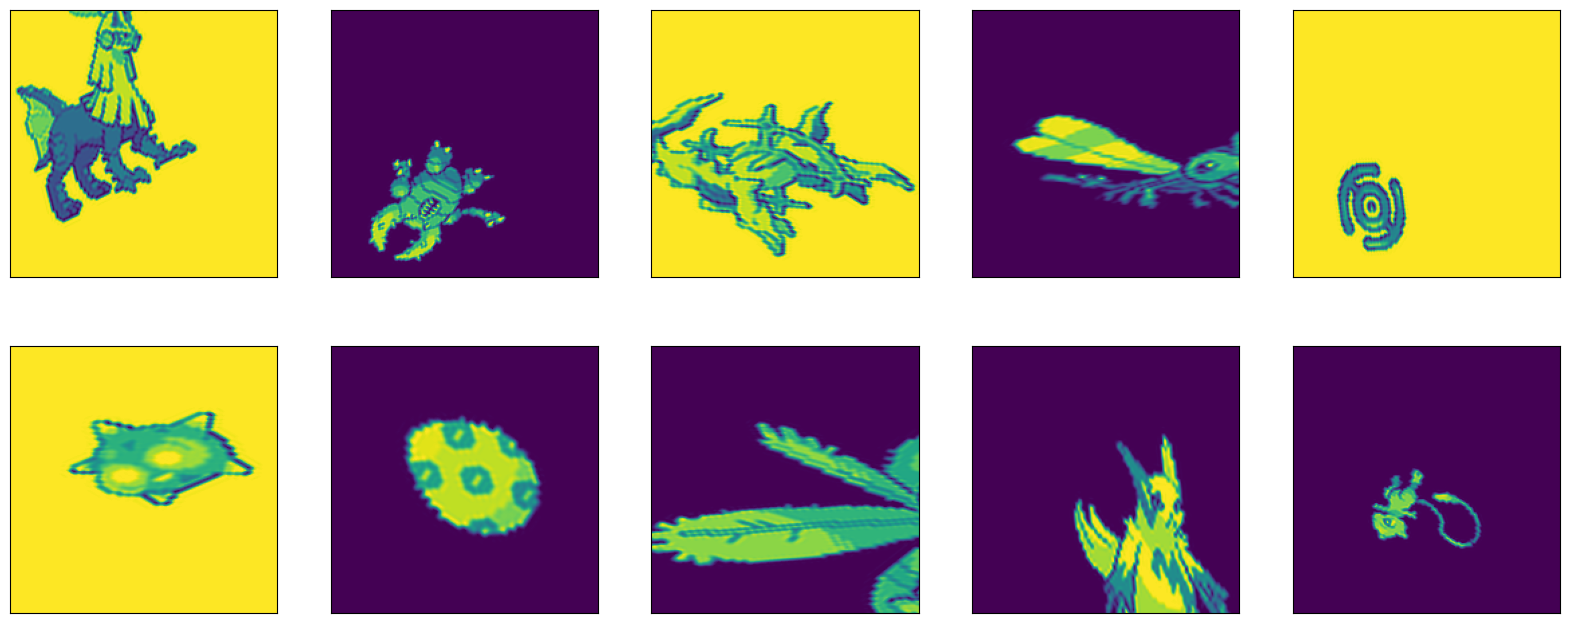

In [6]:
# Visualizar algunas imágenes aumentadas
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    
    # Obtener una imagen aleatoria
    idx = np.random.randint(len(fotos))
    img = fotos[idx]
    
    # Aplicar transformaciones aleatorias
    img_aug = mgTrainGen.random_transform(img)
    
    plt.imshow(img_aug.reshape(ancho, alto))
plt.show()

## Construcción de los modelos

Para la selección del modelo primeramente se contruyen algunas variantes que permitan comparar sus resultados.
- Modelo Denso (Fully Connected)
- Modelo CNN (Convolutional Neural Network)
- Modelo CNN con Dropout

In [7]:
ModeloDenso = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (200, 200, 1)), #conversión a vector unidimensional de 40000 elementos, 200x200, formato que procesan las capas densas
    tf.keras.layers.Dense(150, activation = 'relu'), #introducir no linealidades y acelerar entrenamiento
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'), #clasificación binaria, huevo o pokémon
])

ModeloCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (200, 200, 1)), #los filtros (32, 62, 128) detectan bordes, texturas o formas. Ventana de 3x3 px que se desliza img
    tf.keras.layers.MaxPooling2D(2, 2), #reducción de dimensiones espaciales, prevención de sobreajuste 
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(), #conversión de características 3d a 1d 
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

#con Dropout
ModeloCNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (200, 200, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Dropout(0.5), #regularización para prevenir sobreajuste, desactiva aleatoriamente el 50% neuronas en cada paso
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

d:\Coding\Laboratorios IA\entorno\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Coding\Laboratorios IA\entorno\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


La compilacióm del modelo necesita de un optimizador que actualice los pesos de la red durante el entrenamiento, la función de pérdida que establece cómo medir el error y las métricas definen qué estadísticas se monitorean durante el entrenamiento.

In [8]:
ModeloDenso.compile(
    optimizer = 'adam', #adaptación de tasa de aprendizaje por parámetro y aceleración en la dirección de gradientes consistentes. Estándar en modelos y útil para clasificación binaria
    loss = 'binary_crossentropy', #mide discrepancia entre las predicciones y las etiquetas reales, ideal para capas de salida sigmoide
    metrics = ['accuracy'] #porcentaje de predicciones correctas respecto al total
)

ModeloCNN.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

ModeloCNN2.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)


### Monitoreo de entrenamiento con TensorBoard

Registro de métricas, histogramas de pesos y visualizaciones durante el entrenamiento. Permite comparar el rendimiento de los tres modelos.

In [9]:
BoardDenso = TensorBoard(log_dir = 'logs/Denso')
ModeloDenso.fit(imgTrainGen,batch_size = 32,validation_data = (fotos2, etiquetas2), epochs = 10, callbacks = [BoardDenso], steps_per_epoch = int(np.ceil(len(fotos) /float(32))), validation_steps = int(np.ceil(len(fotos2) /float(32))))

ModeloDenso.save('ModeloDenso.h5')
#ModeloDenso.save_weights('pesosDenso.h5')
print("Modelo Denso guardado")

BoardCNN = TensorBoard(log_dir = 'logs/CNN')
ModeloCNN.fit(imgTrainGen,batch_size = 32,validation_data = (fotos2, etiquetas2), epochs = 10, callbacks = [BoardCNN], steps_per_epoch = int(np.ceil(len(fotos) /float(32))), validation_steps = int(np.ceil(len(fotos2) /float(32))))

ModeloCNN.save('ModeloCNN.h5')
#ModeloCNN.save_weights('pesosCNN.h5')
print("Modelo CNN guardado")

BoardCNN2 = TensorBoard(log_dir = 'logs/CNN2')
ModeloCNN2.fit(imgTrainGen,batch_size = 32,validation_data = (fotos2, etiquetas2), epochs = 10, callbacks = [BoardCNN2], steps_per_epoch = int(np.ceil(len(fotos) /float(32))), validation_steps = int(np.ceil(len(fotos2) /float(32))))

ModeloCNN2.save('ModeloCNN2.h5')
#ModeloCNN2.save_weights('pesosCNN2.h5')
print("Modelo CNN2 guardado")

#tensorboard --logdir="D:\Coding\Laboratorios IA\Deep Learning Escuela\trabajoCNN\logs"

d:\Coding\Laboratorios IA\entorno\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.6386 - loss: 2.6371 - val_accuracy: 0.6708 - val_loss: 4.2942
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7170 - loss: 1.0644 - val_accuracy: 0.8279 - val_loss: 0.6080
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.7397 - loss: 0.5641 - val_accuracy: 0.7057 - val_loss: 1.3720
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.7849 - loss: 0.4929 - val_accuracy: 0.6309 - val_loss: 0.6155
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.7537 - loss: 0.5209 - val_accuracy: 0.7431 - val_loss: 1.6496
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.7638 - loss: 0.5517 - val_accuracy: 0.6633 - val_loss: 0.8931
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.7478 - loss: 0.5661 - val_accuracy: 0.6384 - val_loss: 0.8489
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7747 - loss: 0.4710 - val_accuracy: 0

Modelo Denso guardado
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 667ms/step - accuracy: 0.7312 - loss: 0.4744 - val_accuracy: 0.8354 - val_loss: 0.3953
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 769ms/step - accuracy: 0.8934 - loss: 0.2486 - val_accuracy: 0.8254 - val_loss: 0.2581
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 722ms/step - accuracy: 0.9273 - loss: 0.1792 - val_accuracy: 0.7905 - val_loss: 0.5115
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 674ms/step - accuracy: 0.9048 - loss: 0.2243 - val_accuracy: 0.8329 - val_loss: 0.2221
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 673ms/step - accuracy: 0.9403 - loss: 0.1592 - val_accuracy: 0.8204 - val_loss: 0.4499
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 674ms/step - accuracy: 0.9097 - loss: 0.2098 - val_accuracy: 0.8279 - val_loss: 0.2240
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 793ms/step - accuracy: 0.9266 - loss: 0.2045 - val_accuracy: 0.8180 - val_loss: 0.4224
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 676ms/step - accuracy: 0.9287 - l

Modelo CNN guardado
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 694ms/step - accuracy: 0.7286 - loss: 0.5451 - val_accuracy: 0.8030 - val_loss: 0.3124
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 724ms/step - accuracy: 0.8904 - loss: 0.2707 - val_accuracy: 0.7830 - val_loss: 0.3126
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 706ms/step - accuracy: 0.9074 - loss: 0.2330 - val_accuracy: 0.8105 - val_loss: 0.2406
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 953ms/step - accuracy: 0.9179 - loss: 0.2166 - val_accuracy: 0.8978 - val_loss: 0.2566
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 970ms/step - accuracy: 0.9244 - loss: 0.1809 - val_accuracy: 0.9352 - val_loss: 0.1702
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 726ms/step - accuracy: 0.9135 - loss: 0.2295 - val_accuracy: 0.9651 - val_loss: 0.1482
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 706ms/step - accuracy: 0.9093 - loss: 0.2131 - val_accuracy: 0.8903 - val_loss: 0.1760
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 703ms/step - accuracy: 0.9301 - los

Modelo CNN2 guardado


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step


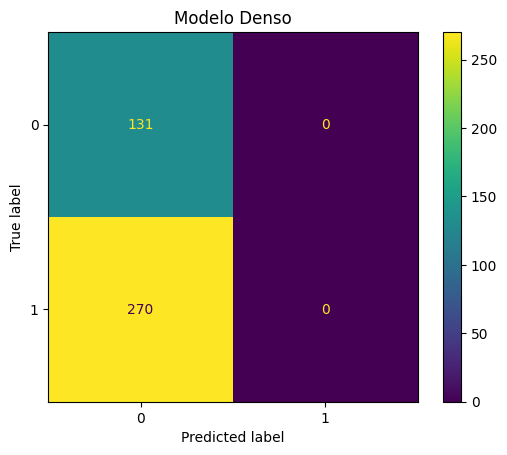

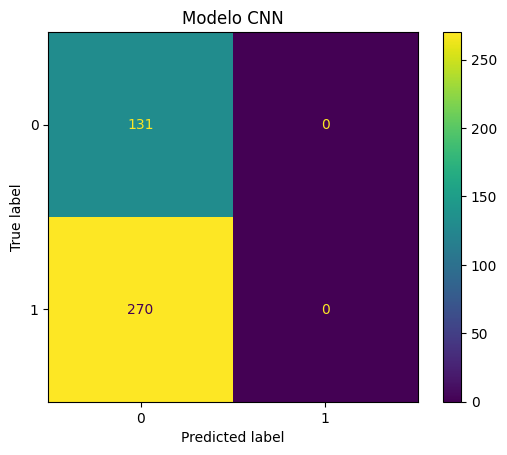

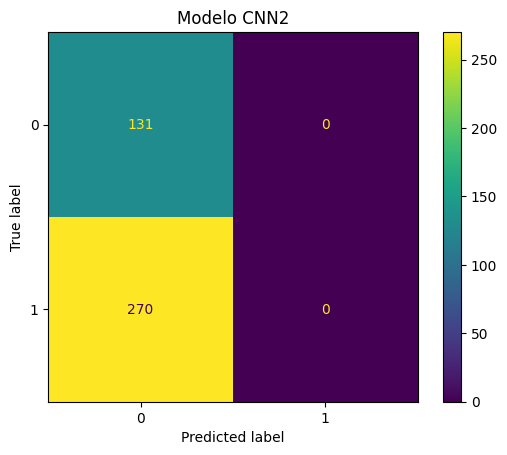

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicciones y conversion a clases
pred_denso = ModeloDenso.predict(fotos2)
pred_cnn = ModeloCNN.predict(fotos2)
pred_cnn2 = ModeloCNN2.predict(fotos2)

clases_denso = np.argmax(pred_denso, axis=1)
clases_cnn = np.argmax(pred_cnn, axis=1)
clases_cnn2 = np.argmax(pred_cnn2, axis=1)

# Función para generar matrices
def generar_matriz(etiquetas, predicciones, titulo):
    matriz = confusion_matrix(etiquetas, predicciones)
    ConfusionMatrixDisplay(matriz).plot()
    plt.title(titulo)
    plt.show()

# Generar matrices para cada modelo
generar_matriz(etiquetas2, clases_denso, "Modelo Denso")
generar_matriz(etiquetas2, clases_cnn, "Modelo CNN")
generar_matriz(etiquetas2, clases_cnn2, "Modelo CNN2")


En todos los casos hubo correctas clasificaciones, 131 huevos y 270 pokemones.